In [51]:

"""
Functions to analyse results
Note:
when you load a mask.nii file (both ground truth and predicted mask)
use
sitk.ReadImage(path_to_file)>0
in order to get a binary image!
"""
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd
import get_data as gd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain

%matplotlib inline

In [52]:
def calculate_dice(mask_a, mask_b):
    """
    Calculate DICE score for two binary masks (=sitk images)
    """
    npa1 = sitk.GetArrayFromImage(mask_a)
    npa2 = sitk.GetArrayFromImage(mask_b)

    dice = 2*np.count_nonzero(npa1 & npa2) / (np.count_nonzero(npa1) + np.count_nonzero(npa2))
    return dice

def calculate_msd(mask_a, mask_b):
    """
    Calulate mean average surface distance between mask a and b
    """
    mask_b.CopyInformation(mask_a)
    # masks need to occupy exactly the same space and no spacial information is
    # saved in the matlab script

    contour_list =[sitk.LabelContour(m) for m in [mask_a, mask_b]]

    n_voxel = []
    mean_val = []

    for a, b in [(0,1), (1,0)]:
        distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(contour_list[a],
                                                         squaredDistance=False,
                                                         useImageSpacing=True))
        stat_intensity_filter = sitk.LabelIntensityStatisticsImageFilter()
        stat_intensity_filter.Execute(contour_list[b], distance_map)
        n_voxel.append(stat_intensity_filter.GetNumberOfPixels(1))
        mean_val.append(stat_intensity_filter.GetMean(1))

    # combine the two values to get 'symmetric' values
    MSD=(n_voxel[0]*mean_val[0]+n_voxel[1]*mean_val[1])/(n_voxel[0]+n_voxel[1])

    return MSD

def mean_columns(dataframe):
    dict = {}
    for column in dataframe:
        dict[column] = [dataframe[column].mean()]
    return dict

In [53]:
result_folder = '/Volumes/My Passport/Ingvild_results'


resultPaths = {}


for experiment in os.listdir(result_folder):
    experimentPath = os.path.join(result_folder, experiment)
    if os.path.isdir(experimentPath):
        for patient in os.listdir(experimentPath):
            patientResultPath = os.path.join(experimentPath, patient)
            if experiment in resultPaths:
                resultPaths[experiment].append(patientResultPath)
            else:
                resultPaths[experiment] = [patientResultPath]

In [54]:
def performance(resultPath_list, groundtruthPath_list):
    
    dice = {}
    msd = {}

    for key in resultPath_list:
        print(key)
        
        # Remove model files (.mat) from the results
        resultPath_list[key] = [filename for filename in resultPath_list[key] if not filename.endswith(".mat")]
        
        for i in range(len(groundtruthPath_list)):
            print(resultPath_list[key][i])
            print(groundtruthPath_list[i])
            if resultPath_list[key][i].endswith('.nii'):
                try:
                    mask_pred = sitk.ReadImage(resultPath_list[key][i]) > 0
                    mask_truth = sitk.ReadImage(groundtruthPath_list[i]) > 0
                    dice_score = calculate_dice(mask_pred, mask_truth)
                    msd_score = calculate_msd(mask_pred, mask_truth)
                    if key in dice:
                        dice[key].append(dice_score)
                        msd[key].append(msd_score)
                    else:
                        dice[key] = [dice_score]
                        msd[key] = [msd_score]
                        
                except ValueError:
                    print('ValueError')
                    if key in dice:
                        dice[key].append(0)
                        msd[key].append(np.nan)
                    else:
                        dice[key] = [0]
                        msd[key] = [np.nan]
    
    return dice, msd

In [55]:
def dataframes(dsc_dict, msd_dict):

    df_dice = pd.DataFrame(dsc_dict)
    df_msd = pd.DataFrame(msd_dict)
    mean_dice = mean_columns(df_dice)
    mean_msd = mean_columns(df_msd)

    df_dice_mean = pd.DataFrame(mean_dice)
    df_msd_mean = pd.DataFrame(mean_msd)
    
    df_dice_median = df_dice.median()
    df_msd_median = df_msd.median()
    
    return df_dice, df_msd, df_dice_mean, df_msd_mean, df_dice_median, df_msd_median

In [56]:
main_folder = '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected'
image_prefix = 'image'

patientsPaths_corrected = []
patientsPaths_image_corrected = []
patientsPaths_groundTruth_corrected = []
patientsNames_corrected = []

for entry in os.listdir(main_folder):
    if not entry.endswith('.DS_Store'):
        patientsPath = os.path.join(main_folder, entry)
        #print(patientsPath)
        if os.path.isdir(patientsPath):
            patientsPaths_corrected.append(patientsPath)
            patientsNames_corrected.append(entry)
            
            for i in os.listdir(patientsPath):
                if i.startswith(image_prefix):
                    patientsPaths_image_corrected.append(os.path.join(patientsPath,i))
                else:
                    patientsPaths_groundTruth_corrected.append(os.path.join(patientsPath,i))
            
print(patientsPaths_groundTruth_corrected)

['/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-label.nii', '/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-010/1 RTSTRUCT LARC_MRS1-label.nii', 

# LARC performance

In [57]:
LARC_patients, LARC_patientsNames, LARC_imagePaths, LARC_groundTruthPaths = gd.get_paths('/Volumes/Untitled/LARC_T2_preprocessed', image_prefix='image', mask_suffix='label.nii')
LARC_groundTruthPaths.insert(0, LARC_groundTruthPaths.pop(len(LARC_groundTruthPaths) - 1))
#print(LARC_groundTruthPaths)

In [58]:
LARC_keys = ['ID_0','ID_1','ID_2','ID_3','ID_4','ID_5','ID_6','ID_7','ID_8'] 
resultPaths_LARC = {x:resultPaths[x] for x in LARC_keys}

#dsc_LARC, msd_LARC = performance(resultPaths_LARC, LARC_groundTruthPaths)
dsc_LARC, msd_LARC = performance(resultPaths_LARC, patientsPaths_groundTruth_corrected)

ID_0
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-001.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-003.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-004.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-005.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-007.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-lab

/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-055.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-057.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-057/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-058.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-058/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-059.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-059/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-060.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-060/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_0/LARC-RRP-062.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-062/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-015.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-015/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-016.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-016/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-017.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-017/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-018.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-018/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-019.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-019/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-020.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-020/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-070.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-070/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-071.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-071/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-072.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-072/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-073.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-073/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-074.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-074/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_1/LARC-RRP-075.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-075/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-027.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-027/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-028.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-028/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-029.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-029/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-030.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-030/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-031.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-031/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-032.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-032/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-081.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-081/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-083.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-083/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-084.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-084/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-085.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-085/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-086.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-086/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_2/LARC-RRP-087.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-087/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-038.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-038/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-039.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-040.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-040/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-041.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-042.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-042/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-043.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-043/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-093.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-093/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-094.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-094/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-095.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-095/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-096.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-096/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_3/LARC-RRP-099.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-099/1 RTSTRUCT LARC_MRS1-label.nii
ID_4
/Volumes/My Passport/Ingvild_results/ID_4/LARC-RRP-001.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-lab

/Volumes/My Passport/Ingvild_results/ID_4/LARC-RRP-050.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-050/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_4/LARC-RRP-051.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-051/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_4/LARC-RRP-052.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-052/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_4/LARC-RRP-053.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-053/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_4/LARC-RRP-054.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-054/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_4/LARC-RRP-055.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-008.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-009.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-010.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-010/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-011.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-011/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-013.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-013/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-014.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-014/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-064.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-064/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-065.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-065/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-066.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-066/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-067.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-067/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-068.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-068/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_5/LARC-RRP-069.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-069/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-022.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-022/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-023.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-023/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-024.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-024/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-026.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-026/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-027.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-027/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-028.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-028/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-077.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-077/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-078.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-078/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-079.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-079/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-080.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-080/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-081.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-081/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_6/LARC-RRP-083.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-083/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-034.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-034/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-035.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-035/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-036.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-036/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-037.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-037/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-038.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-038/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-039.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-089.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-089/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-090.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-090/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-091.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-091/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-092.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-092/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-093.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-093/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_7/LARC-RRP-094.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-094/1 RTSTRUCT LARC_MRS1-label.ni

/Volumes/My Passport/Ingvild_results/ID_8/LARC-RRP-047.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-047/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_8/LARC-RRP-048.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-048/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_8/LARC-RRP-049.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-049/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_8/LARC-RRP-050.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-050/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_8/LARC-RRP-051.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-051/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_8/LARC-RRP-052.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-052/1 RTSTRUCT LARC_MRS1-label.ni

In [65]:
df_dsc_LARC, df_msd_LARC, df_dscMean_LARC, df_msdMean_LARC, df_dscMedian_LARC, df_msdMedian_LARC = dataframes(dsc_LARC, msd_LARC)

LARC_dfs = [df_dsc_LARC, df_msd_LARC, df_dscMean_LARC, df_msdMean_LARC]

for df in LARC_dfs:
    df.rename(columns={'ID_0':'LDA+R0_2D','ID_1':'LDA+R1_2D','ID_2':'LDA+R1_3D','ID_3':'QDA+R0_2D','ID_4':'QDA+R1_2D','ID_5':'QDA+R1_3D','ID_6':'SVM+R0_2D','ID_7':'SVM+R1_2D','ID_8':'SVM+R1_3D'}, inplace=True)


In [66]:
print(df_dsc_LARC)
print(df_msd_LARC)
print(df_dscMean_LARC)
print(df_msdMean_LARC)
print(df_dscMedian_LARC)
print(df_msdMedian_LARC)

    LDA+R0_2D  LDA+R1_2D  LDA+R1_3D  QDA+R0_2D  QDA+R1_2D  QDA+R1_3D  \
0    0.392954   0.416155   0.483339   0.372462   0.322477   0.360829   
1    0.214102   0.260572   0.317352   0.193731   0.248916   0.284858   
2    0.316419   0.305964   0.312877   0.313099   0.201014   0.237110   
3    0.305186   0.364984   0.442705   0.290284   0.334236   0.395990   
4    0.128193   0.122738   0.149216   0.199516   0.221917   0.232561   
..        ...        ...        ...        ...        ...        ...   
84   0.196804   0.253330   0.289359   0.305125   0.194912   0.208448   
85   0.311295   0.336412   0.430301   0.307331   0.285844   0.359926   
86   0.211215   0.233322   0.287892   0.207319   0.187520   0.196462   
87   0.271783   0.277000   0.295082   0.314863   0.164915   0.174154   
88   0.179886   0.203833   0.270075   0.170558   0.143345   0.183497   

    SVM+R0_2D  SVM+R1_2D  SVM+R1_3D  
0    0.353052   0.399380   0.475768  
1    0.194038   0.249150   0.308612  
2    0.273352   0.280

In [67]:
dsc_vals = df_dsc_LARC['LDA+R0_2D'].values
print(LARC_groundTruthPaths[15])
print(dsc_vals[15])
print(dsc_vals)

/Volumes/Untitled/LARC_T2_preprocessed/LARC-RRP-018/1 RTSTRUCT LARC_MRS1-label.nii
0.0449258113526161
[0.39295373 0.21410247 0.31641932 0.3051859  0.12819281 0.28145328
 0.26567936 0.10691116 0.3360793  0.45618071 0.26907499 0.16279859
 0.15326475 0.17186237 0.16910362 0.04492581 0.40265186 0.17568977
 0.12362282 0.02477117 0.40696082 0.46149487 0.26856367 0.04604623
 0.1591419  0.21145749 0.41468163 0.15127139 0.38955556 0.11842375
 0.08029312 0.2035883  0.28816817 0.3037474  0.48333113 0.22109873
 0.16249944 0.20945148 0.16939007 0.30916555 0.07707065 0.07052807
 0.27291301 0.31603771 0.38922257 0.31562509 0.15672633 0.28540264
 0.31673552 0.24556925 0.32049924 0.23932173 0.36999815 0.33549925
 0.20378435 0.41040208 0.17960017 0.22136436 0.23311197 0.24231743
 0.38177778 0.37367538 0.15882071 0.14982744 0.00092886 0.16826689
 0.19155377 0.32343643 0.33865624 0.09768137 0.30521607 0.15477289
 0.32123033 0.30117863 0.10424235 0.25352692 0.23282042 0.24118893
 0.08708883 0.21627428 0.28

# OxyTarget performance

In [68]:
Oxy_keys = ['ID_9','ID_10','ID_11','ID_12','ID_13','ID_14','ID_15','ID_16','ID_17']
resultPaths_Oxy = {x:resultPaths[x] for x in Oxy_keys}

In [69]:
Oxy_patients, Oxy_patientsNames, Oxy_imagePaths, Oxy_groundTruthPaths = gd.get_paths('/Volumes/Untitled 1/Oxytarget_preprocessed', image_prefix='T2', mask_suffix='Manual_an.nii')
#Oxy_groundTruthPaths.insert(0, Oxy_groundTruthPaths.pop(len(Oxy_groundTruthPaths) - 1))
#print(Oxy_groundTruthPaths)

In [70]:
dsc_Oxy, msd_Oxy = performance(resultPaths_Oxy, Oxy_groundTruthPaths)

ID_9
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_103_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_103_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_106_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_106_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_108_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_108_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_110_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_110_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_111_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_111_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_113_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_113_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_115_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_115_PRE/Manual_an.nii
/Volumes/My Passport/I

/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_192_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_192_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_24_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_24_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_27_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_27_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_28_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_28_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_29_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_29_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_31_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_31_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_9/Oxytarget_32_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_32_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID

/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_121_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_121_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_122_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_122_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_123_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_123_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_124_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_124_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_125_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_125_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_126_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_126_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_43_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_43_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_44_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_44_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_45_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_45_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_46_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_46_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_47_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_47_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_48_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_48_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_10/Oxytarget_49_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_49_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_131_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_131_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_133_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_133_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_134_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_134_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_138_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_138_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_143_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_143_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_144_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_144_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_145_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_145_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_52_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_52_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_55_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_55_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_56_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_56_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_57_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_57_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_58_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_58_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_59_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_59_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_11/Oxytarget_61_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_61_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_148_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_148_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_149_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_149_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_150_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_150_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_153_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_153_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_154_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_154_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_155_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_155_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_156_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_156_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_65_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_65_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_67_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_67_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_68_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_68_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_69_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_69_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_72_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_72_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_73_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_73_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_12/Oxytarget_74_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_74_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_160_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_160_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_162_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_162_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_163_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_163_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_164_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_164_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_165_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_165_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_166_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_166_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_169_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_169_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_77_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_77_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_78_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_78_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_79_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_79_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_80_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_80_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_83_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_83_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_85_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_85_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_13/Oxytarget_87_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_87_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_171_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_171_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_172_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_172_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_173_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_173_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_174_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_174_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_175_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_175_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_176_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_176_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_177_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_177_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_90_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_90_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_91_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_91_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_94_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_94_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_95_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_95_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_96_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_96_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_97_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_97_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_14/Oxytarget_99_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_99_PRE/Manual_an.nii
ID_15
/Volumes/My Passport/Ingvild

/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_184_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_15/Oxytarget_185_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_185_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_15/Oxytarget_186_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_186_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_15/Oxytarget_187_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_187_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_15/Oxytarget_188_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_188_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_15/Oxytarget_189_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_189_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_15/Oxytarget_190_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_190_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_15/Oxytarget_191_PRE.nii
/Volumes/Untitled 1/

/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_108_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_108_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_110_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_110_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_111_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_111_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_113_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_113_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_115_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_115_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_116_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_116_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_118_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_118_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_24_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_24_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_27_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_27_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_28_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_28_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_29_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_29_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_31_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_31_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_32_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_32_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_16/Oxytarget_40_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_40_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_122_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_122_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_123_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_123_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_124_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_124_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_125_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_125_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_126_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_126_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_128_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_128_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_44_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_44_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_45_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_45_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_46_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_46_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_47_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_47_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_48_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_48_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_49_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_49_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_17/Oxytarget_50_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_50_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

In [71]:
df_dsc_Oxy, df_msd_Oxy, df_dscMean_Oxy, df_msdMean_Oxy, df_dscMedian_Oxy, df_msdMedian_Oxy = dataframes(dsc_Oxy, msd_Oxy)

print(df_dsc_Oxy)
print(df_msd_Oxy)
print(df_dscMean_Oxy)
print(df_msdMean_Oxy)
print(df_dscMedian_Oxy)
print(df_msdMedian_Oxy)

         ID_9     ID_10     ID_11     ID_12     ID_13     ID_14     ID_15  \
0    0.321825  0.352161  0.369743  0.334971  0.331421  0.301141  0.301000   
1    0.395749  0.410864  0.442214  0.456022  0.299914  0.226402  0.380045   
2    0.404430  0.436244  0.461628  0.394730  0.423936  0.389818  0.383928   
3    0.129603  0.138174  0.162298  0.125053  0.126239  0.129872  0.124412   
4    0.313305  0.334253  0.359209  0.312215  0.324067  0.325896  0.311298   
..        ...       ...       ...       ...       ...       ...       ...   
105  0.240751  0.273049  0.304913  0.253080  0.281045  0.274679  0.252561   
106  0.298596  0.326209  0.360430  0.301283  0.319917  0.301507  0.286046   
107  0.469547  0.499904  0.537736  0.475983  0.492915  0.524643  0.462994   
108  0.301240  0.330789  0.351008  0.300443  0.303938  0.253886  0.293335   
109  0.190517  0.228341  0.272152  0.211070  0.243079  0.255982  0.212476   

        ID_16     ID_17  
0    0.342133  0.365952  
1    0.395882  0.426928

In [72]:
Oxy_dfs = [df_dsc_Oxy, df_msd_Oxy, df_dscMean_Oxy, df_msdMean_Oxy]

for df in Oxy_dfs:
    df.rename(columns={'ID_9':'LDA+R0_2D','ID_10':'LDA+R1_2D','ID_11':'LDA+R1_3D','ID_12':'QDA+R0_2D','ID_13':'QDA+R1_2D','ID_14':'QDA+R1_3D','ID_15':'SVM+R0_2D','ID_16':'SVM+R1_2D', 'ID_17':'SVM+R1_3D'}, inplace=True)


Text(0, 0.5, 'MSD')

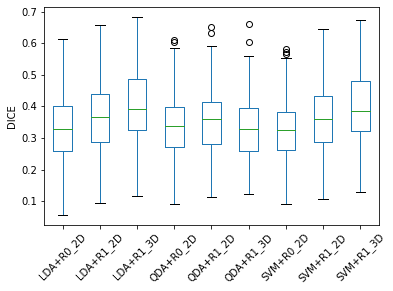

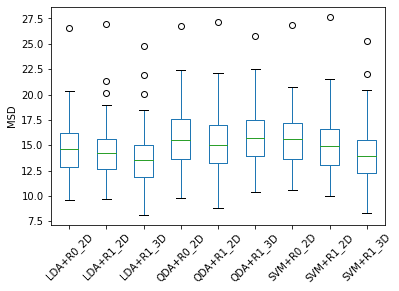

In [73]:
plt.figure()
boxplot_dicedist = df_dsc_Oxy.boxplot(grid=False, rot=45)
plt.ylabel('DICE')

plt.figure()
boxplot_dicedist = df_msd_Oxy.boxplot(grid=False, rot=45)
plt.ylabel('MSD')

# LARC + OxyTarget performance

In [74]:
LARC_Oxy_keys = ['ID_18','ID_19','ID_20','ID_21','ID_22','ID_23','ID_24'] #,'ID_25','ID_26']
resultPaths_LARC_Oxy = {x:resultPaths[x] for x in LARC_Oxy_keys}

In [75]:
#LARC_Oxy_groundTruthPaths = LARC_groundTruthPaths + Oxy_groundTruthPaths
LARC_Oxy_groundTruthPaths =  patientsPaths_groundTruth_corrected + Oxy_groundTruthPaths

In [76]:
dsc_LARC_Oxy, msd_LARC_Oxy = performance(resultPaths_LARC_Oxy, LARC_Oxy_groundTruthPaths)

ID_18
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-001.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-001/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-003.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-004.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-005.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-007.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_M

/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-054.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-054/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-055.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-057.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-057/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-058.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-058/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-059.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-059/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_18/LARC-RRP-060.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-060/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_122_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_122_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_123_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_123_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_124_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_124_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_125_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_125_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_126_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_126_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_128_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_128_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_44_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_44_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_45_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_45_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_46_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_46_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_47_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_47_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_48_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_48_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_49_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_49_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_18/Oxytarget_50_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_50_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-019.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-019/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-020.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-020/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-021.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-021/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-022.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-022/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-023.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-023/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-024.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-024/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-074.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-074/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-075.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-075/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-076.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-076/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-077.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-077/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-078.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-078/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_19/LARC-RRP-079.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-079/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_154_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_154_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_155_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_155_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_156_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_156_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_157_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_157_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_160_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_160_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_162_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_162_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_163_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_163_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_72_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_72_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_73_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_73_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_74_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_74_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_75_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_75_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_77_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_77_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_78_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_78_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_19/Oxytarget_79_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_79_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-038.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-038/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-039.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-040.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-040/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-041.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-042.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-042/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-043.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-043/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-092.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-092/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-093.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-093/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-094.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-094/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-095.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-095/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-096.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-096/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_20/LARC-RRP-099.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-099/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_20/Oxytarget_184_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_184_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_20/Oxytarget_185_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_185_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_20/Oxytarget_186_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_186_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_20/Oxytarget_187_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_187_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_20/Oxytarget_188_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_188_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_20/Oxytarget_189_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_189_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_20/Oxytarget_190_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_190_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-003.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-003/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-004.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-005.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-007.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-008.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-055.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-055/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-057.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-057/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-058.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-058/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-059.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-059/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-060.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-060/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_21/LARC-RRP-062.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-062/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_123_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_123_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_124_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_124_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_125_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_125_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_126_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_126_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_128_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_128_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_130_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_130_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_45_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_45_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_46_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_46_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_47_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_47_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_48_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_48_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_49_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_49_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_50_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_50_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_21/Oxytarget_51_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_51_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-022.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-022/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-023.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-023/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-024.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-024/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-026.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-026/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-027.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-027/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-028.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-028/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-076.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-076/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-077.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-077/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-078.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-078/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-079.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-079/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-080.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-080/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_22/LARC-RRP-081.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-081/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_157_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_157_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_160_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_160_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_162_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_162_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_163_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_163_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_164_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_164_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_165_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_165_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_166_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_166_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_75_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_75_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_77_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_77_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_78_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_78_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_79_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_79_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_80_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_80_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_83_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_83_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_22/Oxytarget_85_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_85_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-039.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-039/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-040.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-040/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-041.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-041/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-042.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-042/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-043.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-043/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-044.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-044/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-093.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-093/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-094.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-094/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-095.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-095/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-096.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-096/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/LARC-RRP-099.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-099/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_103_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_103_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_185_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_185_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_186_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_186_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_187_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_187_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_188_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_188_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_189_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_189_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_190_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_190_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_23/Oxytarget_191_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_191_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-004.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-004/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-005.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-005/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-006.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-006/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-007.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-007/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-008.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-008/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-009.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-009/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-057.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-057/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-058.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-058/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-059.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-059/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-060.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-060/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-062.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-062/1 RTSTRUCT LARC_MRS1-label.nii
/Volumes/My Passport/Ingvild_results/ID_24/LARC-RRP-064.nii
/Users/ingvild/Documents/Prosjektoppgave/Data/LARC_T2_corrected/LARC-RRP-064/1 RTSTRUCT LARC_MRS1-la

/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_124_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_124_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_125_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_125_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_126_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_126_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_127_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_127_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_128_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_128_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_130_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_130_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_131_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_131_PRE/Manual_an.nii
/Volumes/My Passport

/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_46_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_46_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_47_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_47_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_48_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_48_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_49_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_49_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_50_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_50_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_51_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_51_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_results/ID_24/Oxytarget_52_PRE.nii
/Volumes/Untitled 1/Oxytarget_preprocessed/Oxytarget_52_PRE/Manual_an.nii
/Volumes/My Passport/Ingvild_resul

In [77]:
df_dsc_LARC_Oxy, df_msd_LARC_Oxy, df_dscMean_LARC_Oxy, df_msdMean_LARC_Oxy, df_dscMedian_LARC_Oxy, df_msdMedian_LARC_Oxy = dataframes(dsc_LARC_Oxy, msd_LARC_Oxy)

LARC_Oxy_dfs = [df_dsc_LARC_Oxy, df_msd_LARC_Oxy, df_dscMean_LARC_Oxy, df_msdMean_LARC_Oxy]

for df in LARC_Oxy_dfs:
    df.rename(columns={'ID_18':'LDA+R0_2D','ID_19':'LDA+R1_2D','ID_20':'LDA+R1_3D','ID_21':'QDA+R0_2D','ID_22':'QDA+R1_2D','ID_23':'QDA+R1_3D', 'ID_24':'SVM+R0_2D'}, inplace=True)


print(df_dsc_LARC_Oxy)
print(df_msd_LARC_Oxy)
print(df_dscMean_LARC_Oxy)
print(df_msdMean_LARC_Oxy)
print(df_dscMedian_LARC_Oxy)
print(df_msdMedian_LARC_Oxy)

     LDA+R0_2D  LDA+R1_2D  LDA+R1_3D  QDA+R0_2D  QDA+R1_2D  QDA+R1_3D  \
0     0.407408   0.446963   0.534000   0.400932   0.379124   0.434219   
1     0.221244   0.259377   0.325368   0.205161   0.272527   0.334781   
2     0.330960   0.341823   0.409986   0.336884   0.245203   0.265091   
3     0.311378   0.367154   0.448146   0.310677   0.362372   0.429829   
4     0.119362   0.104101   0.100400   0.163605   0.180102   0.217224   
..         ...        ...        ...        ...        ...        ...   
194   0.243609   0.275294   0.306730   0.253753   0.268572   0.243257   
195   0.297019   0.325483   0.359491   0.299470   0.298530   0.254056   
196   0.469592   0.499556   0.536798   0.471634   0.478499   0.494809   
197   0.301089   0.329203   0.345132   0.295463   0.273008   0.230228   
198   0.195797   0.232772   0.277538   0.215009   0.237392   0.204519   

     SVM+R0_2D  
0     0.371607  
1     0.202865  
2     0.293461  
3     0.293540  
4     0.146935  
..         ...  
194 

Text(0, 0.5, 'MSD')

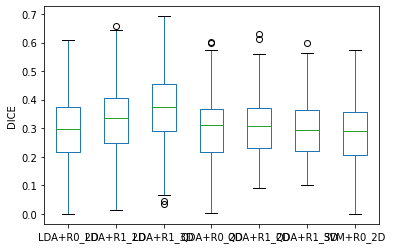

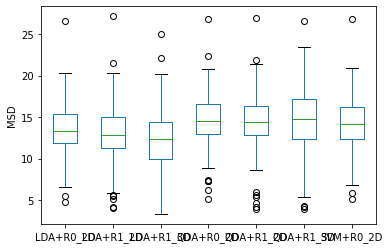

In [78]:
plt.figure()
boxplot_dicedist = df_dsc_LARC_Oxy.boxplot(grid=False)
plt.ylabel('DICE')

plt.figure()
boxplot_dicedist = df_msd_LARC_Oxy.boxplot(grid=False)
plt.ylabel('MSD')

# LARC old performance (before changing NIfTI masks)

In [ ]:
LARC_patients, LARC_patientsNames, LARC_imagePaths, LARC_groundTruthPaths = gd.get_paths('/Volumes/Untitled/LARC_T2_preprocessed', image_prefix='image', mask_suffix='label.nii')
LARC_groundTruthPaths.insert(0, LARC_groundTruthPaths.pop(len(LARC_groundTruthPaths) - 1))
#print(LARC_groundTruthPaths)

In [ ]:
LARC_old_keys = ['ID_0_old','ID_1_old','ID_2_old','ID_3_old','ID_4_old','ID_5_old','ID_6_old','ID_7_old','ID_8_old'] 
resultPaths_LARC_old = {x:resultPaths[x] for x in LARC_old_keys}

dsc_LARC_old, msd_LARC_old = performance(resultPaths_LARC_old, LARC_groundTruthPaths)

In [ ]:
df_dsc_LARC_old, df_msd_LARC_old, df_dscMean_LARC_old, df_msdMean_LARC_old, df_dscMedian_LARC_old, df_msdMedian_LARC_old = dataframes(dsc_LARC_old, msd_LARC_old)

LARC_old_dfs = [df_dsc_LARC_old, df_msd_LARC_old, df_dscMean_LARC_old, df_msdMean_LARC_old]

for df in LARC_old_dfs:
    df.rename(columns={'ID_0_old':'LDA+R0_2D','ID_1_old':'LDA+R1_2D','ID_2_old':'LDA+R1_3D','ID_3_old':'QDA+R0_2D','ID_4_old':'QDA+R1_2D','ID_5_old':'QDA+R1_3D','ID_6_old':'SVM+R0_2D','ID_7_old':'SVM+R1_2D','ID_8_old':'SVM+R1_3D'}, inplace=True)


In [ ]:
print(df_dsc_LARC_old)
print(df_msd_LARC_old)
print(df_dscMean_LARC_old)
print(df_msdMean_LARC_old)
print(df_dscMedian_LARC_old)
print(df_msdMedian_LARC_old)

# Plotting

In [79]:
#DSC
df_dsc_LARC['Data'] = 'LARC'
df_dsc_Oxy['Data'] = 'OxyTarget'
df_dsc_LARC_Oxy['Data'] = 'LARC+OxyTarget'

cdf_dsc = pd.concat([df_dsc_LARC, df_dsc_Oxy, df_dsc_LARC_Oxy])

mdf_dsc = pd.melt(cdf_dsc, id_vars=['Data'], var_name=['Parameters'])
mdf_dsc[['Classification','Unfolding']] = mdf_dsc.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
#print(mdf_dsc)


#MSD
df_msd_LARC['Data'] = 'LARC'
df_msd_Oxy['Data'] = 'OxyTarget'
df_msd_LARC_Oxy['Data'] = 'LARC+OxyTarget'

cdf_msd = pd.concat([df_msd_LARC, df_msd_Oxy, df_msd_LARC_Oxy])

mdf_msd = pd.melt(cdf_msd, id_vars=['Data'], var_name=['Parameters'])
mdf_msd[['Classification','Unfolding']] = mdf_msd.Parameters.apply(lambda x: pd.Series(str(x).split("+")))
#print(mdf_dsc)

In [88]:
def plot_box(dataframe, ylabel):

    plt.figure()
    g = sns.FacetGrid(dataframe, col='Unfolding', row='Classification',margin_titles=True)
    g.map(sns.boxplot,'Data', 'value', palette=['skyblue','orange','mediumseagreen'])
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='x-large')

        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            # This contains the right ylabel text
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='x-large')
            # Remove the original text
            ax.texts[0].remove()
    
    
    g.set_xticklabels(rotation=30)
    g.set_axis_labels('', ylabel)
    g.set(ylim=(-0.05,55))
    plt.show()

    plt.figure()
    g = sns.catplot(x='Unfolding', y='value', hue='Data', col='Classification', data=dataframe, kind='box', palette=['skyblue','orange','mediumseagreen'])
    g.fig.subplots_adjust(wspace=.05, hspace=.05)
    
    """
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='xx-large')
        
        
    g.set_xticklabels(size=15)
    g.set_axis_labels('', ylabel, size=15)
    g.set(ylim=(-0.05,1.05))
    plt.show()
    """

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

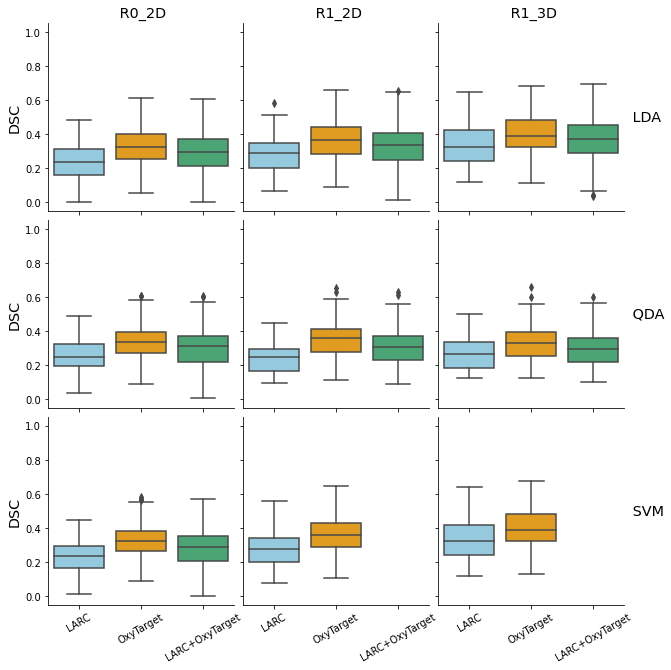

<Figure size 432x288 with 0 Axes>

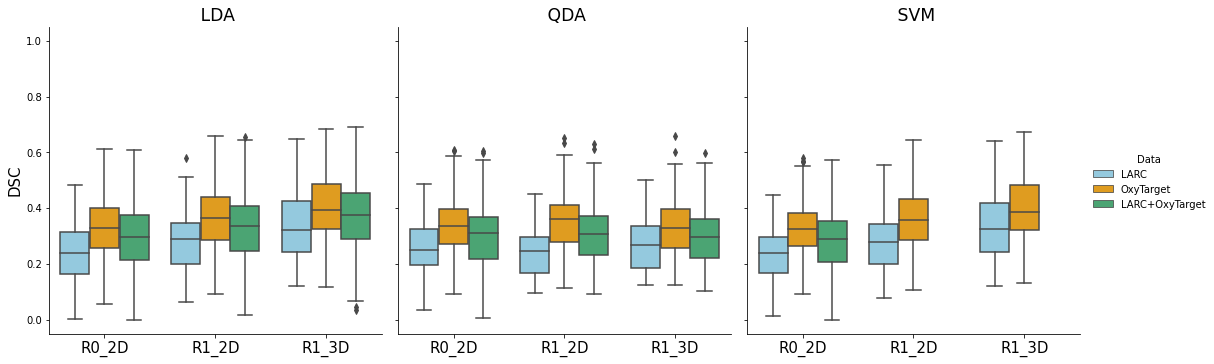

In [83]:
plot_box(mdf_dsc, 'DSC')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 432x288 with 0 Axes>

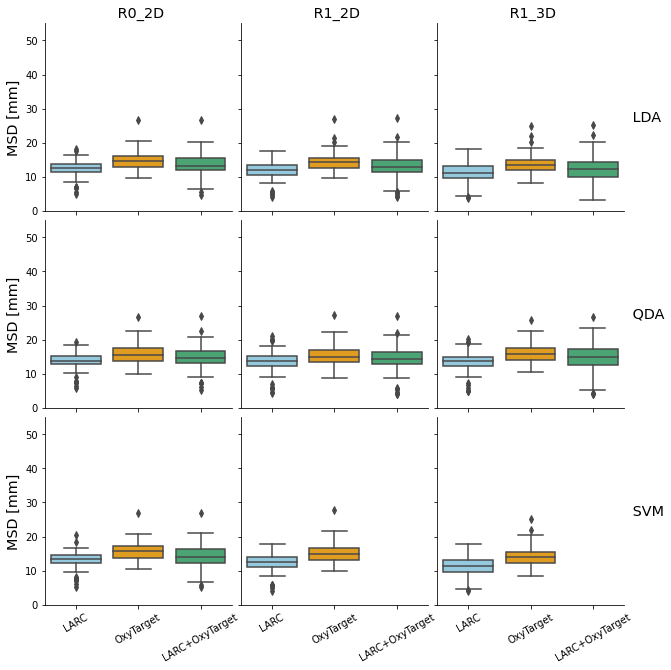

<Figure size 432x288 with 0 Axes>

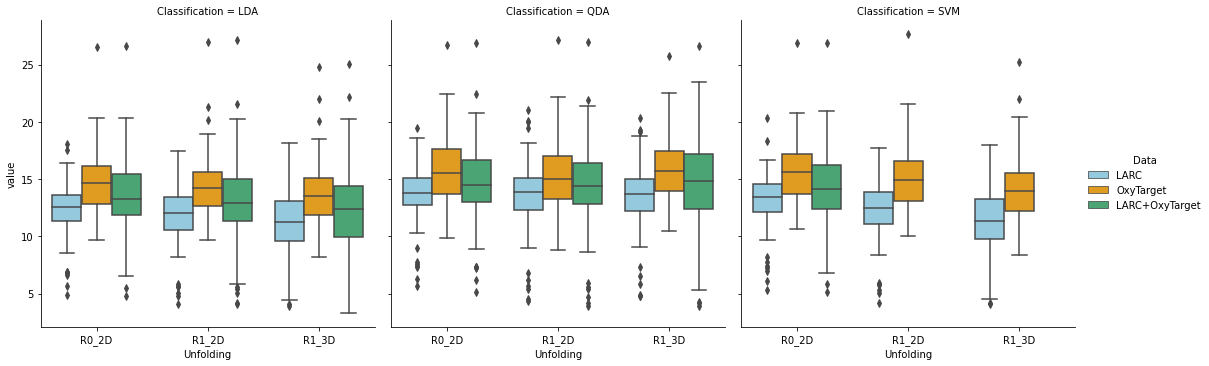

In [89]:
plot_box(mdf_msd, 'MSD [mm]')

In [ ]:
print(df_dsc_LARC.max())
print(df_dsc_Oxy.max())
print(df_dsc_LARC_Oxy.max())

In [ ]:
print(df_dsc_LARC.min())
print(df_dsc_Oxy.min())
print(df_dsc_LARC_Oxy.min())

In [ ]:
min_dsc_value = df_dsc_LARC_Oxy['LDA+R0_2D'].tolist()
print(min(min_dsc_value))
print(min_dsc_value.index(min(min_dsc_value)))
print(resultPaths_LARC_Oxy['ID_18'][64])
msd_list = df_msd_LARC_Oxy['LDA+R0_2D'].tolist()
print(msd_list[181])

In [ ]:
print(df_msd_LARC.min())
print(df_msd_Oxy.min())
print(df_msd_LARC_Oxy.min())

In [ ]:
print(df_msd_LARC.max())
print(df_msd_Oxy.max())
print(df_msd_LARC_Oxy.max())

In [ ]:
print(resultPaths_LARC_Oxy['ID_0'][0])

print(df_dsc_LARC_Oxy['QDA+R0_2D'][89])
print(df_msd_LARC_Oxy['QDA+R0_2D'][89])

# Voxel sizes

In [ ]:
def resolution(image_paths):
    vox_list = []
    for image in range(len(image_paths)):
        vox_list.append(sitk.ReadImage(image_paths[image]).GetSpacing())
    return vox_list


vox_list_LARC = resolution(LARC_imagePaths)
df_vox_LARC = pd.DataFrame(vox_list_LARC, columns=['x','y','z'])

vox_list_Oxy = resolution(Oxy_imagePaths)
df_vox_Oxy = pd.DataFrame(vox_list_Oxy, columns=['x','y','z'])

In [ ]:
print(vox_list_LARC)
pd.set_option('display.max_rows', None)
print(df_vox_LARC)

In [ ]:
print(vox_list_Oxy)
pd.set_option('display.max_rows', None)
print(df_vox_Oxy)

In [ ]:
vox_overview_LARC = Counter(chain(*vox_list_LARC))
df_vox_overview_LARC = pd.DataFrame.from_dict(vox_overview_LARC, orient='index')
print(df_vox_overview_LARC)

In [ ]:
vox_overview_Oxy = Counter(chain(*vox_list_Oxy))
df_vox_overview_Oxy = pd.DataFrame.from_dict(vox_overview_Oxy, orient='index')
print(df_vox_overview_Oxy)

In [ ]:
print(LARC_imagePaths[77])
image = sitk.ReadImage(LARC_groundTruthPaths[77])
array = (sitk.GetArrayFromImage(image)).flatten()

for i in array:
    print(i)


In [ ]:
tumor, non_tumor = gd.data_balance(patientsPaths_groundTruth_corrected)
print(tumor)
print(non_tumor)